<a href="https://colab.research.google.com/github/SughoshDixit/Video-Activity-Recognition-using-CNN---LSTM/blob/main/DL_Assignment_2_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:verdana;"> <center>📚Group No - 136📚</center> </h1>
<h1 style="font-family:verdana;"> <center> Deep Learning - Assignment 2 - Video Activity Recognition
</center> </h1>
<p><center style="color:#159364; font-family:cursive;">UCF - 101 Dataset</center></p>
<p><center style="color:#159364; font-family:cursive;">
 <table>
  <tr>
    <th>Name</th>
  </tr>
  <tr>
    <td>Sughosh P Dixit</td>
  </tr>
</table> 
</p>

![Stay Home](https://cdn.dribbble.com/users/6228692/screenshots/17752308/media/3479d7421ad72d75ddea3b00a62ba488.png?compress=1&resize=1000x750&vertical=top)
<cite>Image from www.dribbble.com by 
Papay Paperpillar</cite>

## 1. Import Libraries/Dataset (0 mark)

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import time
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## 2. Data Processing(1 mark)

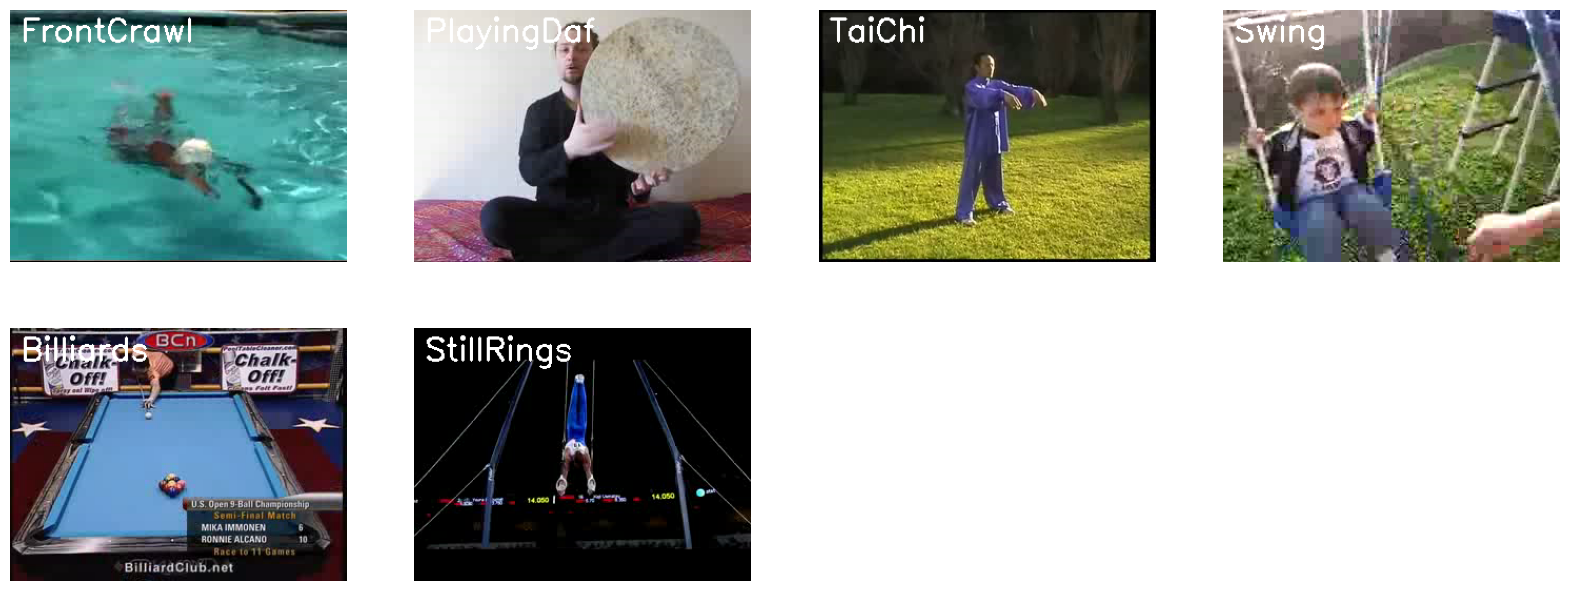

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(r'dataset/')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(rf'dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(rf'dataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 50

# Specify the directory containing the  dataset. 
DATASET_DIR = r"dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["normal","crime"]
CLASSES_LIST= ["Shotput","Surfing","JumpingJack","JumpRope","Lunges","PullUps","YoYo"]

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Shotput
Extracting Data of Class: Surfing
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Lunges
Extracting Data of Class: PullUps
Extracting Data of Class: YoYo


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,)
                                                        

## 3. Model Building (4 mark)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 50, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 50, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 50, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 50, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 50, 15, 15, 8)    0         
 3D)                                                             
                                                        

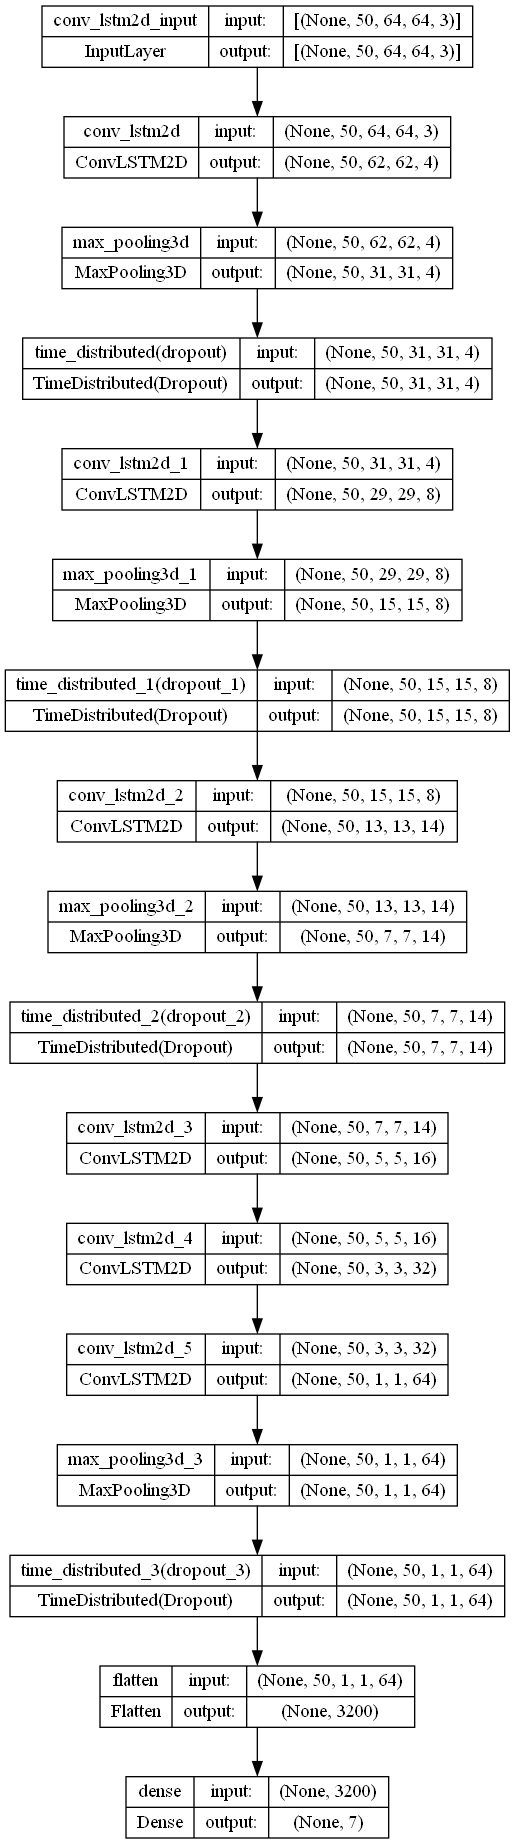

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 125, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 64,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/150
6/6 [==============================] - 197s 29s/step - loss: 1.9302 - accuracy: 0.1942 - val_loss: 1.8587 - val_accuracy: 0.2292
Epoch 2/150
6/6 [==============================] - 173s 29s/step - loss: 1.8700 - accuracy: 0.2205 - val_loss: 1.7537 - val_accuracy: 0.2188
Epoch 3/150
6/6 [==============================] - 171s 28s/step - loss: 1.6990 - accuracy: 0.2546 - val_loss: 1.7178 - val_accuracy: 0.1771
Epoch 4/150
6/6 [==============================] - 169s 28s/step - loss: 1.6526 - accuracy: 0.2336 - val_loss: 1.6770 - val_accuracy: 0.1771
Epoch 5/150
6/6 [==============================] - 183s 31s/step - loss: 1.6314 - accuracy: 0.2231 - val_loss: 1.6667 - val_accuracy: 0.2396
Epoch 6/150
6/6 [==============================] - 173s 29s/step - loss: 1.6281 - accuracy: 0.2362 - val_loss: 1.6587 - val_accuracy: 0.2396
Epoch 7/150
6/6 [==============================] - 177s 29s/step - loss: 1.6240 - accuracy: 0.2415 - val_loss: 1.6632 - val_accuracy: 0.1771
Epoch 8/150
6

Epoch 59/150
6/6 [==============================] - 172s 29s/step - loss: 1.2438 - accuracy: 0.4646 - val_loss: 1.3193 - val_accuracy: 0.4271
Epoch 60/150
6/6 [==============================] - 176s 30s/step - loss: 1.2520 - accuracy: 0.4698 - val_loss: 1.3465 - val_accuracy: 0.4792
Epoch 61/150
6/6 [==============================] - 174s 29s/step - loss: 1.1887 - accuracy: 0.5223 - val_loss: 1.3496 - val_accuracy: 0.5417
Epoch 62/150
6/6 [==============================] - 172s 29s/step - loss: 1.1721 - accuracy: 0.5249 - val_loss: 1.1743 - val_accuracy: 0.5521
Epoch 63/150
6/6 [==============================] - 172s 29s/step - loss: 1.1069 - accuracy: 0.5381 - val_loss: 1.1985 - val_accuracy: 0.5312
Epoch 64/150
6/6 [==============================] - 172s 29s/step - loss: 1.0931 - accuracy: 0.5354 - val_loss: 1.3075 - val_accuracy: 0.5312
Epoch 65/150
6/6 [==============================] - 171s 29s/step - loss: 1.1021 - accuracy: 0.5669 - val_loss: 1.2217 - val_accuracy: 0.5417
Epoch 

6/6 [==============================] - 173s 29s/step - loss: 0.4064 - accuracy: 0.8661 - val_loss: 0.9328 - val_accuracy: 0.7396
Epoch 117/150
6/6 [==============================] - 173s 29s/step - loss: 0.3852 - accuracy: 0.8766 - val_loss: 0.9637 - val_accuracy: 0.7083
Epoch 118/150
6/6 [==============================] - 172s 29s/step - loss: 0.3651 - accuracy: 0.8635 - val_loss: 0.9348 - val_accuracy: 0.7083
Epoch 119/150
6/6 [==============================] - 171s 29s/step - loss: 0.3019 - accuracy: 0.9081 - val_loss: 0.9980 - val_accuracy: 0.7396
Epoch 120/150
6/6 [==============================] - 172s 29s/step - loss: 0.2502 - accuracy: 0.9160 - val_loss: 1.0011 - val_accuracy: 0.7396
Epoch 121/150
6/6 [==============================] - 173s 29s/step - loss: 0.2585 - accuracy: 0.8924 - val_loss: 1.1591 - val_accuracy: 0.7500
Epoch 122/150
6/6 [==============================] - 172s 29s/step - loss: 0.2355 - accuracy: 0.9344 - val_loss: 0.9394 - val_accuracy: 0.7188
Epoch 123/150

## 4. Model Compilation (2 mark)

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 13s 3s/step - loss: 0.5830 - accuracy: 0.8491


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

## 5. Model Training (2 mark)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

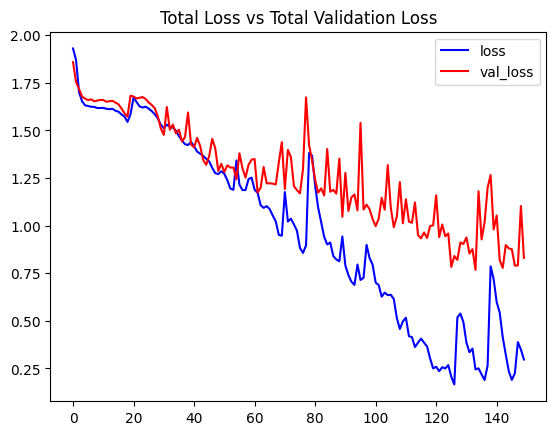

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

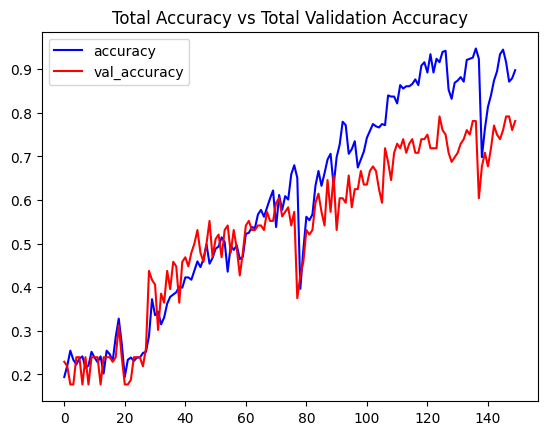

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 50, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 50, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 50, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 50, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 50, 4, 4, 32)    

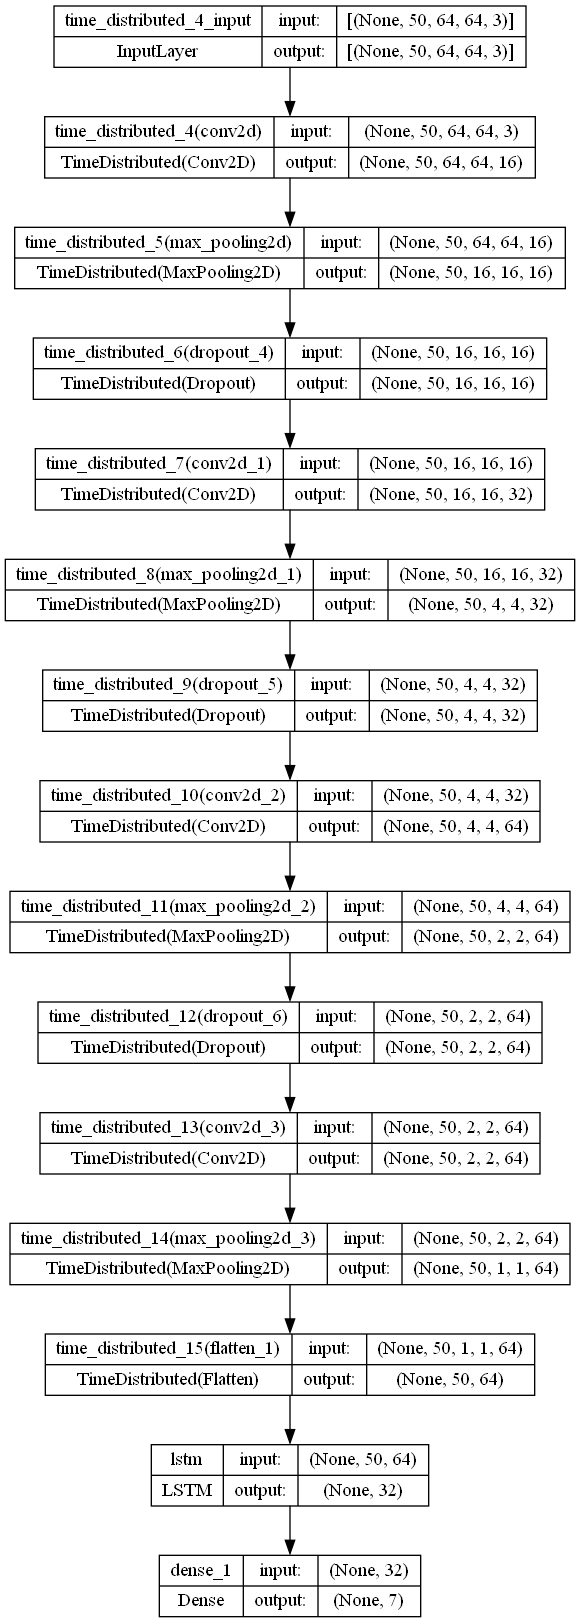

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
96/96 [==============================] - 21s 188ms/step - loss: 1.7116 - accuracy: 0.2073 - val_loss: 1.6750 - val_accuracy: 0.2396
Epoch 2/70
96/96 [==============================] - 16s 170ms/step - loss: 1.6423 - accuracy: 0.2362 - val_loss: 1.6464 - val_accuracy: 0.2396
Epoch 3/70
96/96 [==============================] - 16s 166ms/step - loss: 1.6031 - accuracy: 0.2651 - val_loss: 1.6729 - val_accuracy: 0.2708
Epoch 4/70
96/96 [==============================] - 16s 167ms/step - loss: 1.4729 - accuracy: 0.3858 - val_loss: 1.3722 - val_accuracy: 0.4583
Epoch 5/70
96/96 [==============================] - 16s 168ms/step - loss: 1.3277 - accuracy: 0.4619 - val_loss: 1.2913 - val_accuracy: 0.5104
Epoch 6/70
96/96 [==============================] - 16s 168ms/step - loss: 1.2269 - accuracy: 0.5328 - val_loss: 1.3394 - val_accuracy: 0.4375
Epoch 7/70
96/96 [==============================] - 16s 168ms/step - loss: 1.1683 - accuracy: 0.5538 - val_loss: 1.3065 - val_accuracy: 0.5312

Epoch 58/70
96/96 [==============================] - 16s 166ms/step - loss: 0.2180 - accuracy: 0.9239 - val_loss: 0.9882 - val_accuracy: 0.6979
Epoch 59/70
96/96 [==============================] - 16s 167ms/step - loss: 0.4153 - accuracy: 0.8740 - val_loss: 0.3920 - val_accuracy: 0.8854
Epoch 60/70
96/96 [==============================] - 16s 165ms/step - loss: 0.0989 - accuracy: 0.9764 - val_loss: 0.3681 - val_accuracy: 0.8958
Epoch 61/70
96/96 [==============================] - 16s 165ms/step - loss: 0.2089 - accuracy: 0.9344 - val_loss: 0.8263 - val_accuracy: 0.7708
Epoch 62/70
96/96 [==============================] - 16s 165ms/step - loss: 0.2047 - accuracy: 0.9291 - val_loss: 0.4041 - val_accuracy: 0.8646
Epoch 63/70
96/96 [==============================] - 16s 166ms/step - loss: 0.0892 - accuracy: 0.9764 - val_loss: 0.3486 - val_accuracy: 0.8958


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

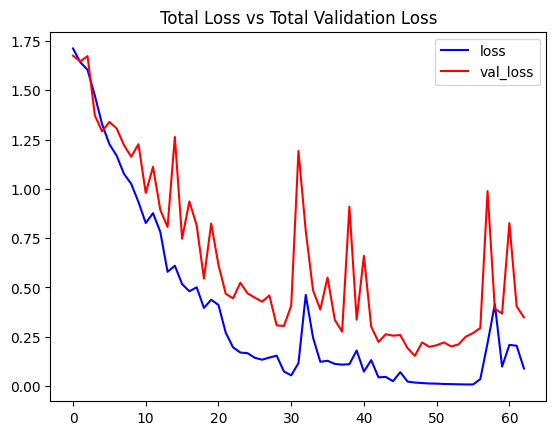

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

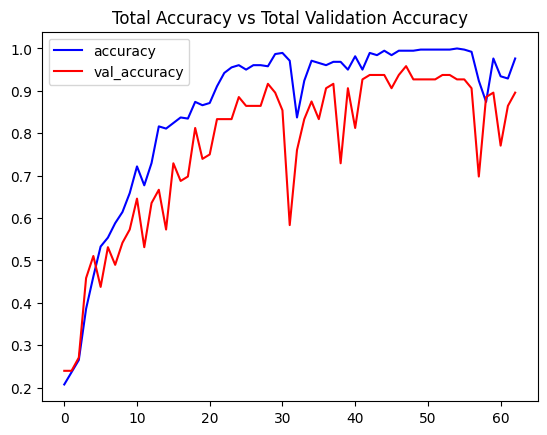

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## 6. Model Evaluation (1 mark)

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
        import time
        from tensorflow import keras
        tf.compat.v1.debugging.set_log_device_placement(True)
#         print(tf.config.list_physical_devices('GPU'))
        
        LRCN_model = keras.models.load_model(r'convlstm_model___Date_Time_2023_03_21__15_17_16___Loss_0.5829830765724182___Accuracy_0.849056601524353.h5')
        
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

Real Time Prediction on a Video 

In [ ]:
SEQUENCE_LENGTH=50
# Construct the output video path.
output_video_file_path = r'C:\Users\WIN10\Jupyter Notebooks\Video Activity Recognition\output_result.avi'
print(output_video_file_path)

# Perform Action Recognition on the Test Video.
model_time=time.time()
predict_on_video(r'C:\Users\WIN10\Jupyter Notebooks\Video Activity Recognition\input1.avi', output_video_file_path, SEQUENCE_LENGTH)

print("model time taken:",1/(time.time()-model_time) )
# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()
print("Video Write Successfull")

C:\Users\WIN10\Jupyter Notebooks\Video Activity Recognition\output_result.avi
1/1 [==============================] - 1s 1s/step
model time taken: 0.003706423956510917
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
Video Write Successfull
